<a href="https://colab.research.google.com/github/VallentinDS/Data-Science-Projects/blob/main/House_Rent_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Uploading the data from kaggle

!pip install -q kaggle
from google.colab import files
from google.colab import drive

!touch "/content/kaggle.json"

# files.upload()

!mkdir ~/.kaggle
!echo '{"username":"valentinciocrlan","key":"8b6430191445b54bcdb25c2afe5eb33c"}' > ~/.kaggle/kaggle.json
# !cp kaggle.json ~/.kaggle/

# JSON data
# username	"valentinciocrlan"
# key	"8b6430191445b54bcdb25c2afe5eb33c"

!chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download -d iamsouravbanerjee/house-rent-prediction-dataset -p /content/House_Rent_Predictions_dataset// --unzip


  0% 0.00/82.4k [00:00<?, ?B/s]
100% 82.4k/82.4k [00:00<00:00, 51.7MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/House_Rent_Predictions_dataset/Dataset Glossary.txt') as f:
    data_description = f.read()
    
print("Data Discription")
print(data_description)

Data Discription
BHK: Number of Bedrooms, Hall, Kitchen.

Rent: Rent of the Houses/Apartments/Flats.

Size: Size of the Houses/Apartments/Flats in Square Feet.

Floor: Houses/Apartments/Flats situated in which Floor and Total Number of Floors (Example: Ground out of 2, 3 out of 5, etc.)

Area Type: Size of the Houses/Apartments/Flats calculated on either Super Area or Carpet Area or Build Area.

Area Locality: Locality of the Houses/Apartments/Flats.

City: City where the Houses/Apartments/Flats are Located.

Furnishing Status: Furnishing Status of the Houses/Apartments/Flats, either it is Furnished or Semi-Furnished or Unfurnished.

Tenant Preferred: Type of Tenant Preferred by the Owner or Agent.

Bathroom: Number of Bathrooms.

Point of Contact: Whom should you contact for more information regarding the Houses/Apartments/Flats.


In [ ]:
# importing the libraries

import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.animation as animation
%matplotlib inline

# Installing the kneed package.
# Uncomment and Re-run it when running the notebook again if using scikit-learn
# At the moment, I went for a manual application of the algorithm 

# !pip install kneed
# !pip install scikit-learn ipython

# visualisation setup
plt.style.use("fivethirtyeight")
sns.set_style('whitegrid')


In [ ]:
house_rent_dataset = pd.read_csv("/content/House_Rent_Predictions_dataset/House_Rent_Dataset.csv")
house_rent_dataset

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner
...,...,...,...,...,...,...,...,...,...,...,...,...
4741,2022-05-18,2,15000,1000,3 out of 5,Carpet Area,Bandam Kommu,Hyderabad,Semi-Furnished,Bachelors/Family,2,Contact Owner
4742,2022-05-15,3,29000,2000,1 out of 4,Super Area,"Manikonda, Hyderabad",Hyderabad,Semi-Furnished,Bachelors/Family,3,Contact Owner
4743,2022-07-10,3,35000,1750,3 out of 5,Carpet Area,"Himayath Nagar, NH 7",Hyderabad,Semi-Furnished,Bachelors/Family,3,Contact Agent
4744,2022-07-06,3,45000,1500,23 out of 34,Carpet Area,Gachibowli,Hyderabad,Semi-Furnished,Family,2,Contact Agent


In [ ]:
house_rent_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          4746 non-null   object
 1   BHK                4746 non-null   int64 
 2   Rent               4746 non-null   int64 
 3   Size               4746 non-null   int64 
 4   Floor              4746 non-null   object
 5   Area Type          4746 non-null   object
 6   Area Locality      4746 non-null   object
 7   City               4746 non-null   object
 8   Furnishing Status  4746 non-null   object
 9   Tenant Preferred   4746 non-null   object
 10  Bathroom           4746 non-null   int64 
 11  Point of Contact   4746 non-null   object
dtypes: int64(4), object(8)
memory usage: 445.1+ KB


# Data Cleaning

Actions to take:
1. Renaming the columns to make them more pythonic
2. Reframe the Floor column so that it will only have the the floor where it is 
3. Add another column where it will be the total number of floors 
4. Turn the 'Posted on' column to a datetime type
5. 'Point of contact' column can indicate if the apartments are company or private owned. This can be used as to classify the prices depending on the type of ownership
6. Convert the type of other columns to other types using `.astype()`


For this stage, these will be the points that I will be working on

In [ ]:
# transforming the 'Posted on' column to a datetime type

# creating a copy of the orignal dataframe
house_df = house_rent_dataset.copy()

# converting the column to a datetime type
house_df['Posted On'] = pd.to_datetime(house_df['Posted On'])


In [ ]:
# Renaming the columns and replacing them directly in `house_df` dataframe

house_df.rename(columns= {
    'Posted On': 'date',
    'BHK': 'number_of_rooms',
    'Rent': 'price',
    'Size': 'size_sqft',
    'Area Type': 'area_type',
    'Area Locality': 'area_locality',
    'City': 'city',
    'Furnishing Status': 'furnishing',
    'Tenant Preferred': 'tenant_preferred',
    'Bathroom': 'number_of_bathroom'
}, inplace= True)

In [ ]:
# Transforming tenant_preferred and furnishing columns into categorical data

house_df['tenant_preferred'] = house_df['tenant_preferred'].astype('category')
house_df['furnishing'] = house_df['furnishing'].astype('category')

In [ ]:
# Assigning new values to the Lower Basement, Upper Basement and Ground floors in order to later have a categorical variable

house_df['Floor'] = house_df['Floor'].str.replace('Ground', '0').str.replace('Lower Basement', '-2').str.replace('Upper Basement', '-1')

In [ ]:
house_df['Floor'].head(5)

0    0 out of 2
1    1 out of 3
2    1 out of 3
3    1 out of 2
4    1 out of 2
Name: Floor, dtype: object

In [ ]:
# Function for getting the first number to determine de floor
def get_floor_number(x):
  return x.split(' ')[0].strip()
  

# Function for getting the last number to determine the total amount of floors
def get_total_floors(x):
  return x.split(' ')[-1].strip()

house_df['floor'] = house_df['Floor'].apply(lambda x: get_floor_number(x))
house_df['total_floors'] = house_df['Floor'].apply(lambda x: get_total_floors(x))

In [ ]:
# Computing the price per square foot

house_df['price_per_sqft'] = np.round(house_df['price'] / house_df['size_sqft'])

In [ ]:
house_df.head()

,date,number_of_rooms,price,size_sqft,Floor,area_type,area_locality,city,furnishing,tenant_preferred,number_of_bathroom,Point of Contact,floor,total_floors,price_per_sqft
0,2022-05-18,2,10000,1100,0 out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,0,2,9.0
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1,3,25.0
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1,3,17.0
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,1,2,12.0
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner,1,2,9.0


# Data Analysis

I will be going into presenting some general descriptive statistics and summary stats for this data set using a class method

In [ ]:
class BasicAnalysis:

  def __init__(self, data):
    self.data = data

  def analysis(self):
    column_list = self.data.columns.tolist()
    print("Name of columns:: ", column_list)
    print('\n')

    # checking to see if there is any column with missing data
    columns_with_missing_data = self.data.columns[self.data.isnull().any()].tolist()
    print("Columns with missing data:: ", columns_with_missing_data)
    print('\n')

    # generating the general statistics about the dataframe
    general_stats = self.data.describe()
    print("General Statistics:: \n", general_stats)
    print()

    summary_stats = self.data.info
    print("Summary statistics::\n", summary_stats)

In [ ]:
obj = BasicAnalysis(house_df)
obj.analysis()

Name of columns::  ['date', 'number_of_rooms', 'price', 'size_sqft', 'Floor', 'area_type', 'area_locality', 'city', 'furnishing', 'tenant_preferred', 'number_of_bathroom', 'Point of Contact', 'floor', 'total_floors', 'price_per_sqft']


Columns with missing data::  []


General Statistics:: 
        number_of_rooms         price    size_sqft  number_of_bathroom  \
count      4746.000000  4.746000e+03  4746.000000         4746.000000   
mean          2.083860  3.499345e+04   967.490729            1.965866   
std           0.832256  7.810641e+04   634.202328            0.884532   
min           1.000000  1.200000e+03    10.000000            1.000000   
25%           2.000000  1.000000e+04   550.000000            1.000000   
50%           2.000000  1.600000e+04   850.000000            2.000000   
75%           3.000000  3.300000e+04  1200.000000            2.000000   
max           6.000000  3.500000e+06  8000.000000           10.000000   

       price_per_sqft  
count     4746.000000  


It seems that in the `size_sqft` there are some outliers, which imapacted also the data in the `price_per_sqft`.



In [ ]:
house_df['floor'].isnull().value_counts()

False    4746
Name: floor, dtype: int64

In [ ]:
# Converting the floor and total_floors columns to int

house_df['floor'] = house_df['floor'].astype('int')
house_df['total_floors'] = house_df['total_floors'].astype('int')

# Univariate Analysis



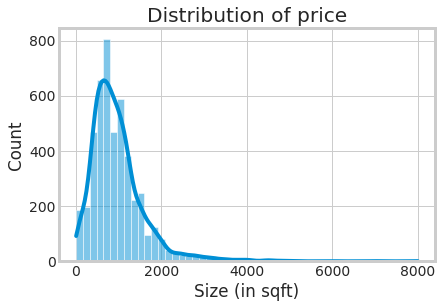

In [ ]:
# Distribution of the size of the house

sns.histplot(data= house_df,
             x = 'size_sqft',
             bins = 50,
             kde= True)

plt.xlabel("Size (in sqft)")
plt.title("Distribution of price")
plt.show()


The distribution of size is right skewed

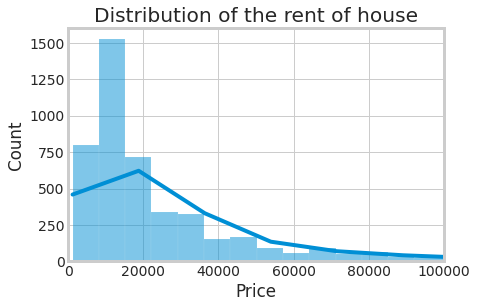

In [ ]:
# Distribution of house rent

sns.histplot(data= house_df,
             x= 'price',
             bins = 500,
             kde = True)

plt.xlabel('Price')
plt.xlim(0, 100000)
plt.title('Distribution of the rent of house')
plt.show()

The distribution of house rent is right skewed. 

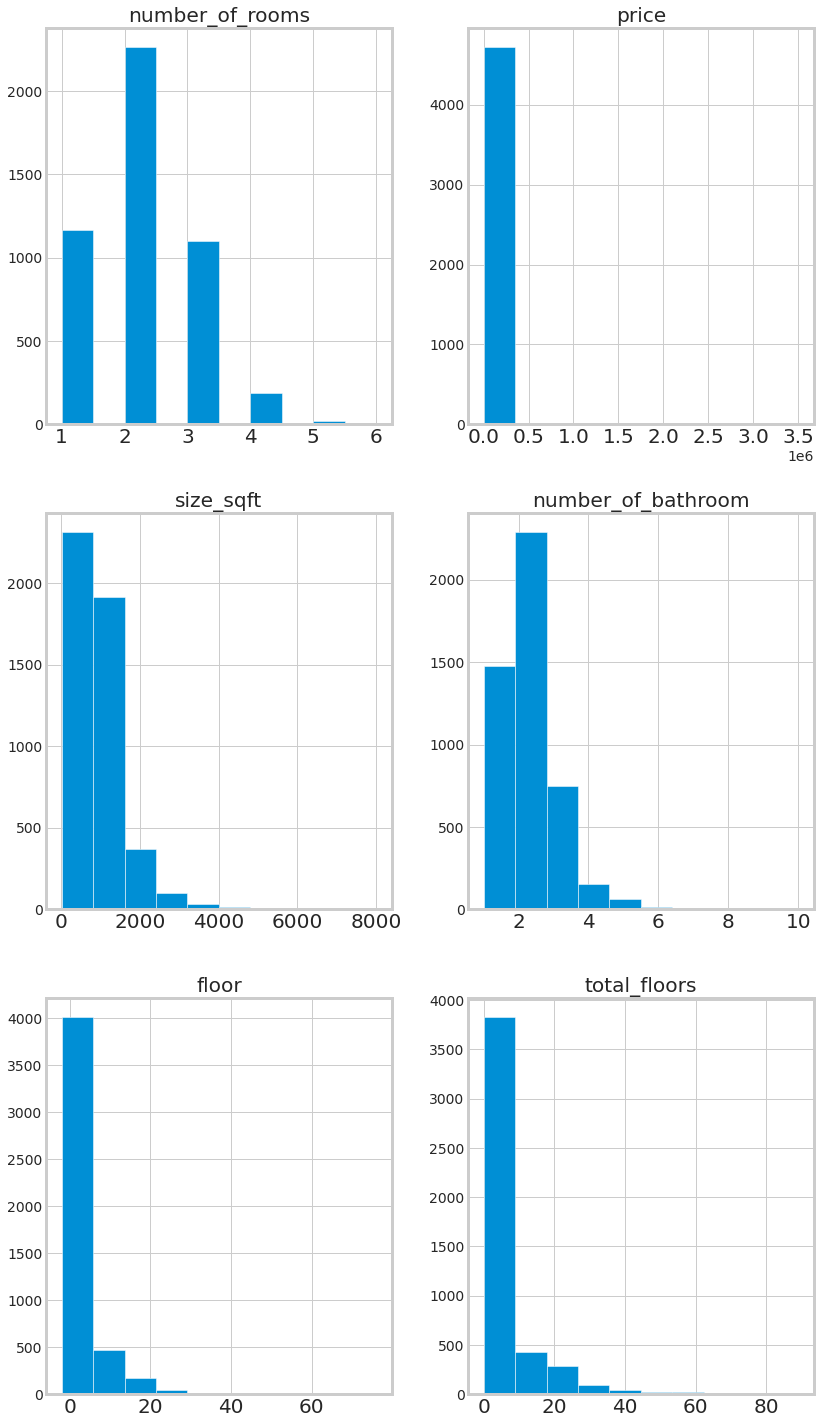

In [ ]:
numeric_columns = house_df.select_dtypes(include='int').columns.tolist()
house_df[numeric_columns].hist(xlabelsize=20)
plt.tight_layout(h_pad=2, w_pad= 2, rect=(3, 1, 5, 6))

# Outliers

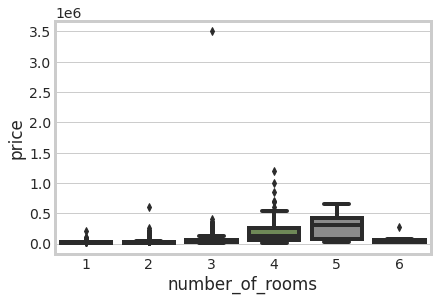

In [ ]:
# 
sns.boxplot(y= 'price', x= 'number_of_rooms', data= house_df)

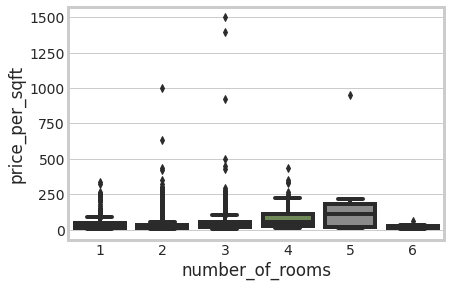

In [ ]:
sns.boxplot(y= 'price_per_sqft', x= 'number_of_rooms', data= house_df)

In [ ]:
# finding the outlier and dropping it
# There is a house with a rent of 3500000 that is skeweing the results. Will remove it

house_df.loc[house_df['price'] > 1500000]
house_df.drop(house_df.loc[house_df['price'] > 1500000].index, inplace= True)

In [ ]:
# writing a function to detect any other outlier

def detect_outlier(df, columns):
  outlier_indices = []

  for c in columns:
    # defining the 1st quartile, which is the first 25% percent
    q1 = np.percentile(df[c], 25)

    # defining the 3rd quartile
    q3 = np.percentile(df[c], 75)

    # Interquartile
    iqr = q3 - q1

    # outlier step
    outlier_step = iqr * 1.5

    # detect the outlier and its indices
    outlier_list_col = df[(df[c] < q1 - outlier_step) | (df[c] > q3 + outlier_step)]

    # store indices
    outlier_indices.extend(outlier_list_col)

  # Counter stores the elements as dictionary keys and their count as dictionary value
  outlier_indices = Counter(outlier_indices)
  multiple_outlier = list(i for i, v in outlier_indices.items() if v > 2)

  return multiple_outlier


In [ ]:
house_df.loc[detect_outlier(house_df, ['price', 'price_per_sqft'])]

,date,number_of_rooms,price,size_sqft,Floor,area_type,area_locality,city,furnishing,tenant_preferred,number_of_bathroom,Point of Contact,floor,total_floors,price_per_sqft


As we can see, there are no more outliers in the dataset.

With the dataset now cleaned, we can try to look at how to use K-means clustering. As a clustering algorithm, I will use the **partitional clustering**.

In [ ]:
house_df

,date,number_of_rooms,price,size_sqft,Floor,area_type,area_locality,city,furnishing,tenant_preferred,number_of_bathroom,Point of Contact,floor,total_floors,price_per_sqft
0,2022-05-18,2,10000,1100,0 out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,0,2,9.0
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1,3,25.0
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1,3,17.0
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,1,2,12.0
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner,1,2,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4741,2022-05-18,2,15000,1000,3 out of 5,Carpet Area,Bandam Kommu,Hyderabad,Semi-Furnished,Bachelors/Family,2,Contact Owner,3,5,15.0
4742,2022-05-15,3,29000,2000,1 out of 4,Super Area,"Manikonda, Hyderabad",Hyderabad,Semi-Furnished,Bachelors/Family,3,Contact Owner,1,4,14.0
4743,2022-07-10,3,35000,1750,3 out of 5,Carpet Area,"Himayath Nagar, NH 7",Hyderabad,Semi-Furnished,Bachelors/Family,3,Contact Agent,3,5,20.0
4744,2022-07-06,3,45000,1500,23 out of 34,Carpet Area,Gachibowli,Hyderabad,Semi-Furnished,Family,2,Contact Agent,23,34,30.0


In [ ]:
print('The minimum price is: ', house_df['price'].min())
print('The maximum price is: ', house_df['price'].max())

The minimum price is:  1200
The maximum price is:  1200000


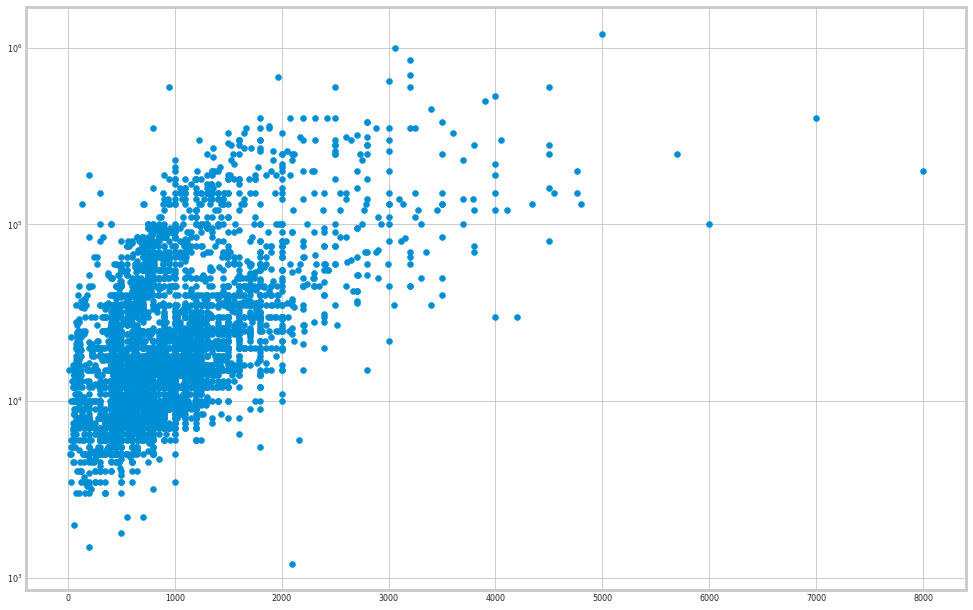

In [ ]:
customcmap = ListedColormap(['crimson', 'mediumblue', 'darkmagenta'])

fig, ax = plt.subplots(figsize=(15,10))
plt.scatter(x= house_df['size_sqft'],
            y= house_df['price'])
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.yscale("log")
plt.show()

# K-Means Clustering

In [ ]:
# function that will set k centroids from the given dataset

def set_centroids(k, dataset):

  '''
  Select k data points as centroids from the dataset
  k: number of centroids
  ''' 
  centroids = dataset.sample(k)
  return centroids

# setting the seed for reproduceability
np.random.seed(0) 
k=3
size_price = house_df[['size_sqft', 'price']]
centroids = set_centroids(k, house_df[['size_sqft', 'price']])
centroids

,size_sqft,price
3327,1450,20000
1836,2080,60000
1272,550,65000


In [ ]:
centroids.shape

(3, 2)

In [ ]:
# function for calculating the distance between each centroid and the data points using Euclidean Distance

def calculate_distance(a, b):
  '''
  Calculate the Euclidean distance.
  a and b are numpy arrays
  '''

  return np.sqrt(np.sum((a-b)**2))

# picking a data point and calculating the distance to the centroids
# ideally, the error/distance between the data point and the centroid should be zero
# then that data point will be assigned to the second centroid
for i, centroid in enumerate(range(centroids.shape[0])): 
  distance = calculate_distance(centroids.iloc[centroid,:], size_price.iloc[1272,:])
  print('Error for centroid {0}: {1:.2f}'.format(i, distance))

Error for centroid 0: 45009.00
Error for centroid 1: 5228.85
Error for centroid 2: 0.00


In [ ]:
print(range(0,2))

range(0, 2)


In [ ]:
# assign centroids

def assign_centroid(dataset, centroids):
  '''
  Given a dataset and a set of "centroids", we assign each data point in dataset
  to a centroid.
  - dataset = pandas dataframe with observations
  - centroids - 
  '''
  k = centroids.shape[0]
  n = dataset.shape[0]
  assignation = []
  assign_distance = []

  for obs in range(n):
    # Estimate the distance
    all_distance = np.array([])
    for centroid in range(k):
      distance = calculate_distance(centroids.iloc[centroid,:], size_price.iloc[obs,:])
      all_distance = np.append(all_distance, distance)

    # Get the nearest centroid and the error
    nearest_centroid = np.where(all_distance==np.amin(all_distance))[0].tolist()[0]
    nearest_centroid_distance = np.amin(all_distance)

    # Add values to the initial lists
    assignation.append(nearest_centroid)
    assign_distance.append(nearest_centroid_distance)

  return assignation, assign_distance



In [ ]:
# Adding the columns 'centroid' and 'distance' in order to see which data point belongs to which cluster and how far it is for the centre

size_price['centroid'], size_price['distance'] = assign_centroid(size_price, centroids)
size_price['centroid'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0    3815
2     568
1     362
Name: centroid, dtype: int64

In [ ]:
size_price.head()

,size_sqft,price,centroid,distance
0,1100,10000,0,10006.123125
1,800,20000,0,650.000000
2,1000,17000,0,3033.562262
3,800,10000,0,10021.102734
4,850,7500,0,12514.391715


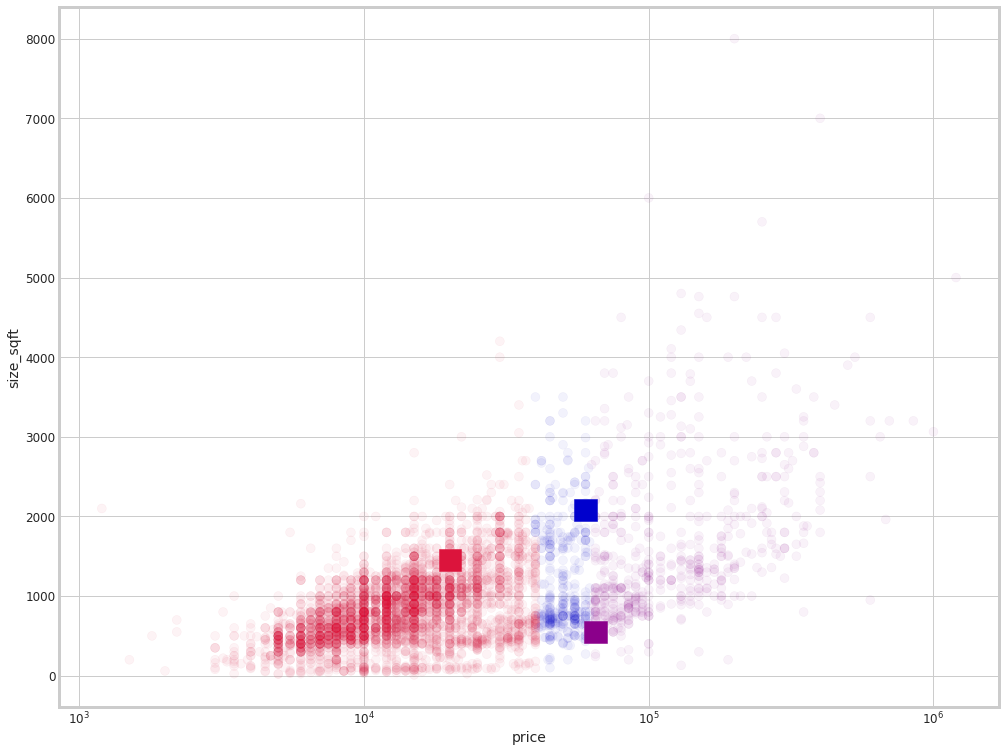

In [ ]:
fig, ax = plt.subplots(figsize=(15,12))
plt.scatter(size_price.iloc[:,1], size_price.iloc[:,0], marker= 'o',
            c= size_price['centroid'].astype('category'),
            cmap= customcmap, s=80, alpha=0.05)
plt.scatter(centroids.iloc[:,1], centroids.iloc[:,0],
            marker= 's', s=500, c=[0, 1, 2],
            cmap= customcmap, alpha= 1)
ax.set_xlabel(r'price', fontsize= 14)
ax.set_ylabel(r'size_sqft', fontsize= 14)
plt.yticks(fontsize= 12)
plt.xticks(fontsize= 12)
plt.xscale("log")
plt.show()

In [ ]:
print("The total distance is {0:.2f}".format(size_price['distance'].sum()))

The total distance is 83840178.17


In [ ]:
colnames = list(size_price.columns[0:2])
colnames

NameError: ignored

In [ ]:
# After we have defined our clusters, now it is time to calculate the new k centroids' location until the distance does not change anymore

centroids = size_price.groupby('centroid').agg('mean').loc[:, colnames].reset_index(drop=True)
centroids

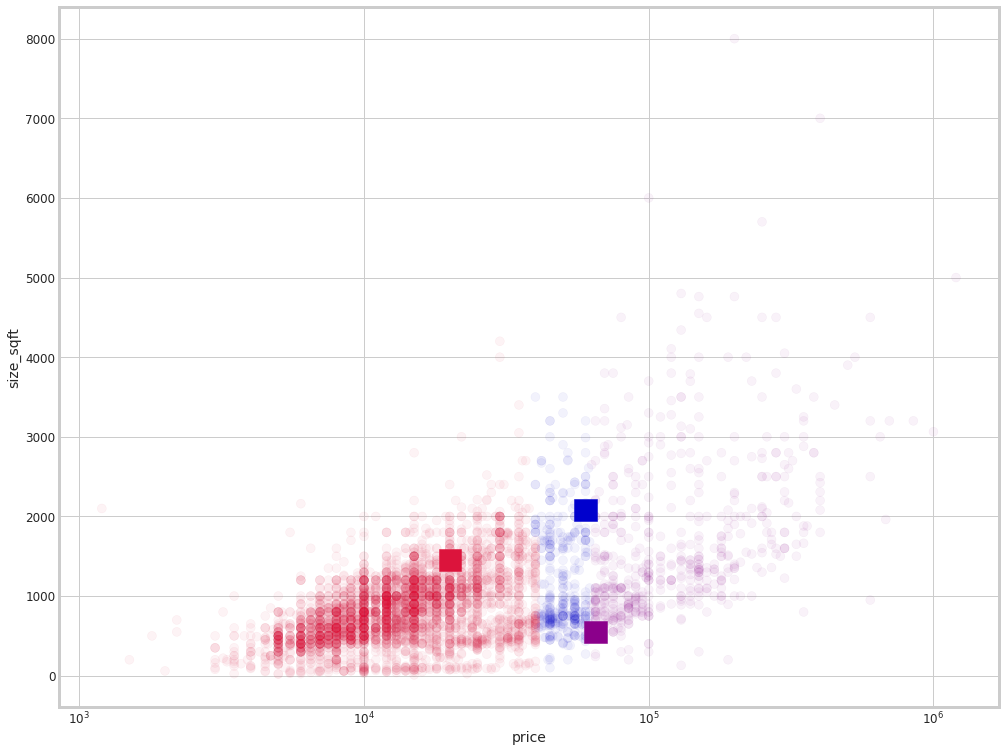

In [ ]:
# verifying if the position was updated

fig, ax = plt.subplots(figsize=(15,12))
plt.scatter(size_price.iloc[:,1], size_price.iloc[:,0], marker= 'o',
            c= size_price['centroid'].astype('category'),
            cmap= customcmap, s=80, alpha=0.05)
plt.scatter(centroids.iloc[:,1], centroids.iloc[:,0],
            marker= 's', s=500, c=[0, 1, 2],
            cmap= customcmap, alpha= 1)
ax.set_xlabel(r'price', fontsize= 14)
ax.set_ylabel(r'size_sqft', fontsize= 14)
plt.yticks(fontsize= 12)
plt.xticks(fontsize= 12)
plt.xscale("log")
plt.show()

In [ ]:
print("The total distance is {0:.2f}".format(size_price['distance'].sum()))

The total distance is 83840178.17


In [ ]:
from tables.utils import dump_logged_instances

def kmeans_func (dataset, k=3, distance_tolerance= 0.1, max_iterations= 500):
  data = dataset.copy() # creating a copy of the original dataset to not mess the data
  distance = [] # variable to store the distance
  reiterate = True # variable acting as a stopping signal 
  iterations_counter = 0 # a counter for iterations

  # Initiating the clusters by defining the centroids
  centroids = set_centroids(k, dataset)

  while(reiterate):
    # assigning the centroids and calculating the distance
    data['centroid'], data_point_distance = assign_centroid(data, centroids)
    distance.append(sum(data_point_distance))

    # updating the centroid position
    centroids = data.groupby('centroid').agg('mean').reset_index(drop=True)

    # reitare the previous steps until we reach the desired tolerance
    if iterations_counter > 0:
      # is the distance less than the tolerance we set
      if distance[iterations_counter - 1] - distance[iterations_counter] <= distance_tolerance:
        reiterate = False

    iterations_counter += 1

    if iterations_counter > max_iterations:
      break
      
  dataset['centroid'], data_point_distance = assign_centroid(data, centroids)
  centroids = data.groupby('centroid').agg('mean').reset_index(drop=True)

  return data['centroid'], data_point_distance, centroids

In [ ]:
np.random.seed(0)

size_price['centroid'], size_price['distance'], centroids = kmeans_func(size_price[['size_sqft','price']], 3)
size_price.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,size_sqft,price,centroid,distance
0,1100,10000,0,5071.356142
1,800,20000,0,4935.944149
2,1000,17000,0,1943.335884
3,800,10000,0,5064.231694
4,850,7500,0,7564.172276


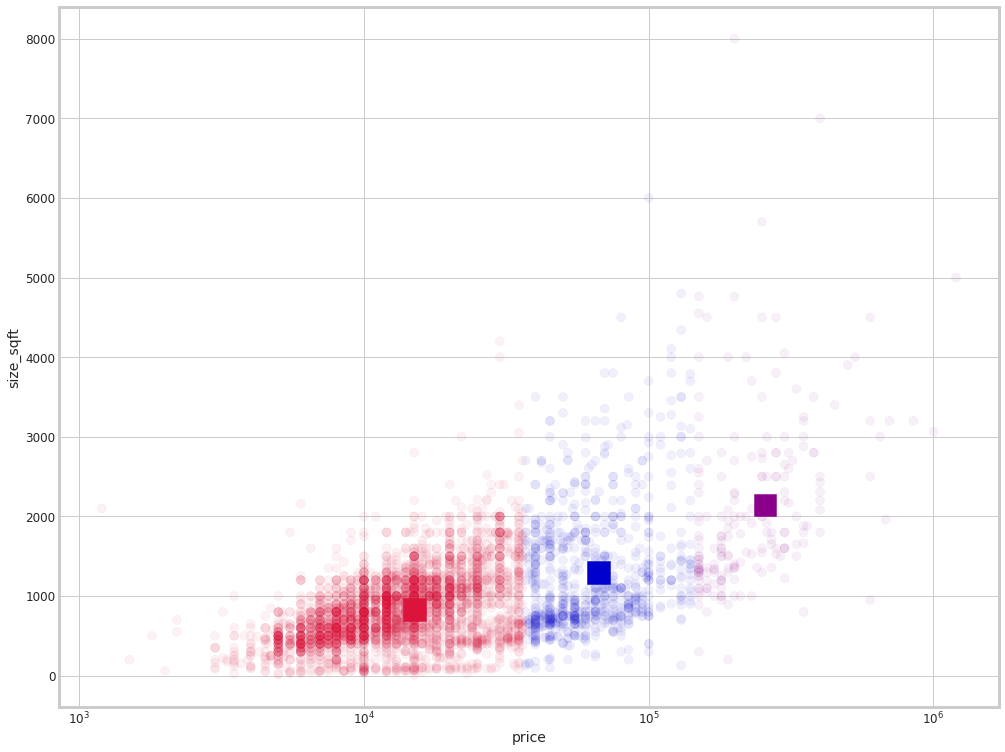

In [ ]:
fig, ax = plt.subplots(figsize=(15,12))
plt.scatter(size_price.iloc[:,1], size_price.iloc[:,0], marker= 'o',
            c= size_price['centroid'].astype('category'),
            cmap= customcmap, s=80, alpha=0.06)
plt.scatter(centroids.iloc[:,1], centroids.iloc[:,0],
            marker= 's', s=500, c=[0, 1, 2],
            cmap= customcmap, alpha= 2)
ax.set_xlabel(r'price', fontsize= 14)
ax.set_ylabel(r'size_sqft', fontsize= 14)
plt.yticks(fontsize= 12)
plt.xticks(fontsize= 12)
plt.xscale("log")
plt.show()

The clusters seem to be perfectly defined and the centroids quite well alligned in the middle of their clusters.

The following course of action would be to find the correct number of centroids/clusters (k) and how to correctly choose them.

Questions for Nikolaos:
- we know that clustering is mainly used for finding commonalities between our data observations when labelled data is not available. Can you give me an example of situations where K-means Clustering can be used?
  - group users based on their browser history, but we don't know how to define the groups. we don't know in which group they belong. K-Means helps group us the users based on their charactheristics
  - the caveat is that we don't know the quality of the clusters
      - based on the conversion rate, if a group of users has high conversion rate => represents

- The data above seems to have some sort of linearity. You mention last time that we can use this with linear regression. What would be the process?
  - 


In [ ]:
# normalize the price and size_sqft 
size_price['price'] = (size_price['price'] - size_price['price'].min()) / (size_price['price'].max() - size_price['price'].min())
size_price['size_sqft'] = (size_price['size_sqft'] - size_price['size_sqft'].min()) / (size_price['size_sqft'].max() - size_price['size_sqft'].min())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
size_price.head()

,size_sqft,price,centroid,distance
0,0.136421,0.002515,2,3964.173226
1,0.098874,0.005373,2,6046.092689
2,0.123905,0.004516,2,3051.676960
3,0.098874,0.002515,2,3953.955354
4,0.105131,0.001801,2,6454.020366


In [ ]:
size_price['centroid'], size_price['distance'], centroids = kmeans_func(size_price[['size_sqft','price']], 3)
size_price.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,size_sqft,price,centroid,distance
0,0.136421,0.002515,1,0.006282
1,0.098874,0.005373,1,0.036946
2,0.123905,0.004516,1,0.012499
3,0.098874,0.002515,1,0.037316
4,0.105131,0.001801,1,0.031315


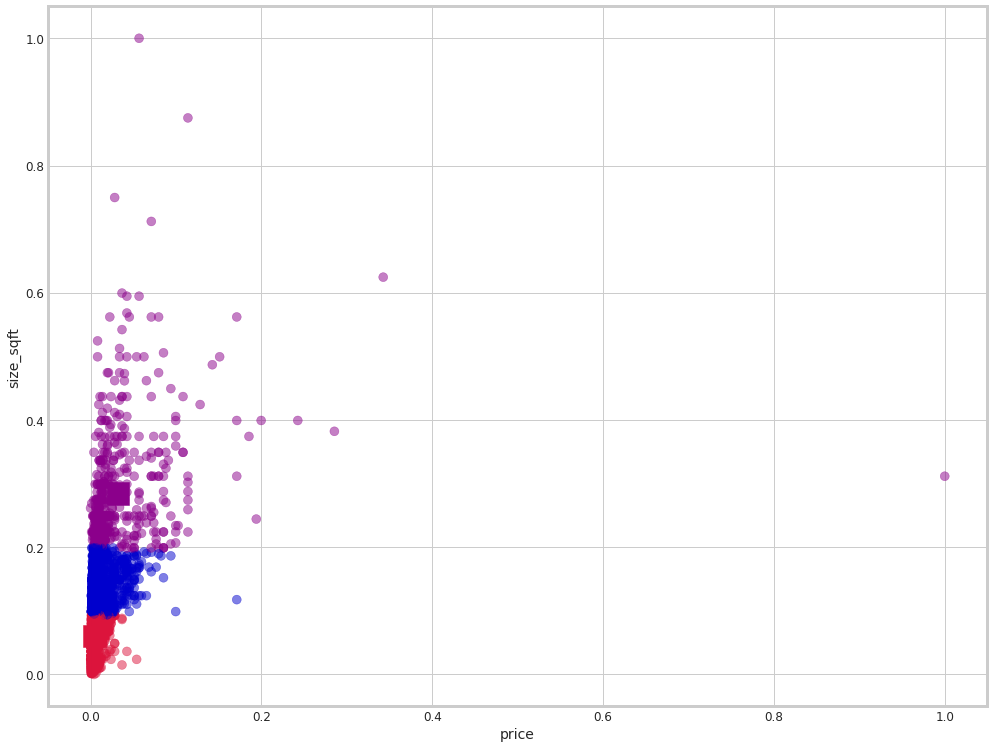

In [ ]:
fig, ax = plt.subplots(figsize=(15,12))
plt.scatter(size_price.iloc[:,1], size_price.iloc[:,0], marker= 'o',
            c= size_price['centroid'].astype('category'),
            cmap= customcmap, s=80, alpha=0.5)
plt.scatter(centroids.iloc[:,1], centroids.iloc[:,0],
            marker= 's', s=500, c=[0, 1, 2],
            cmap= customcmap, alpha= 1)
ax.set_xlabel(r'price', fontsize= 14)
ax.set_ylabel(r'size_sqft', fontsize= 14)
plt.yticks(fontsize= 12)
plt.xticks(fontsize= 12)
# plt.xscale("log")
plt.show()

In [ ]:
size_price['price'].max()